--- Simulating 500 Steps ---
--- Simulation Complete ---


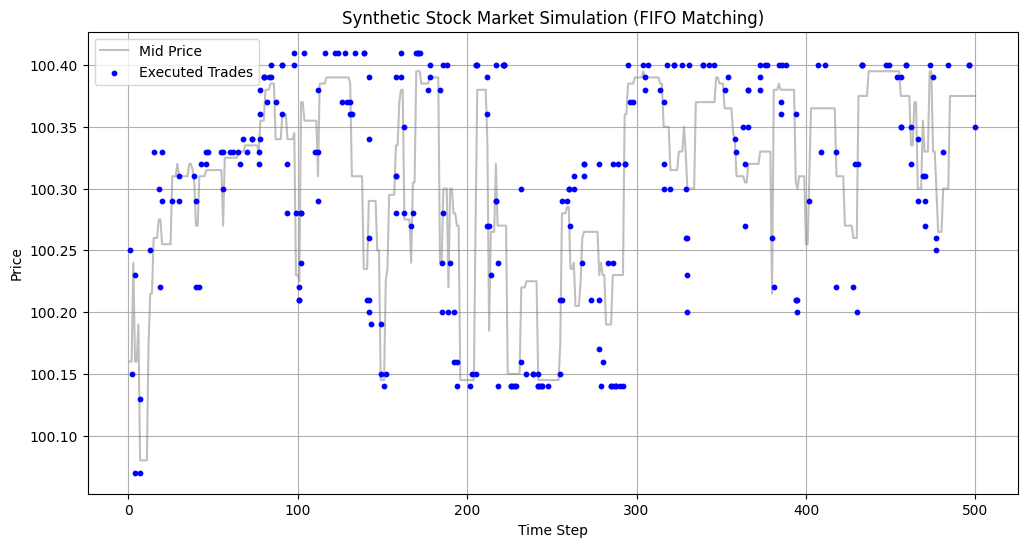


--- Final L2 Snapshot ---
BIDS (Buyers Waiting):
Qty 3 @ 100.35 (AgID: 2)
Qty 2 @ 100.34 (AgID: 3)
Qty 3 @ 100.32 (AgID: 2)
Qty 2 @ 100.2 (AgID: 2)
Qty 2 @ 100.2 (AgID: 2)

ASKS (Sellers Waiting):
Qty 9 @ 100.4 (AgID: 1)
Qty 10 @ 100.4 (AgID: 1)
Qty 10 @ 100.4 (AgID: 1)
Qty 10 @ 100.4 (AgID: 1)
Qty 5 @ 100.4 (AgID: 4)


In [1]:
import random
import pandas as pd
import matplotlib.pyplot as plt
import time
from dataclasses import dataclass, field
from typing import List, Optional

# --- 1. CONFIGURATION KNOBS ---
TICK_SIZE = 0.01
LOT_SIZE = 1
SIMULATION_STEPS = 500
MID_PRICE_START = 100.0
VOLATILITY = 0.2

# --- 2. DATA STRUCTURES ---
@dataclass
class Order:
    id: int
    agent_id: int
    side: str  # 'buy' or 'sell'
    price: float
    qty: int
    timestamp: int

@dataclass
class Trade:
    price: float
    qty: int
    buyer_id: int
    seller_id: int
    timestamp: int

# --- 3. THE MATCHING ENGINE (ORDER BOOK) ---
class OrderBook:
    def __init__(self):
        self.bids: List[Order] = [] # High prices first
        self.asks: List[Order] = [] # Low prices first
        self.trades: List[Trade] = []
        self.order_id_counter = 0

    def add_order(self, order: Order):
        # 1. Try to Match (Aggressive)
        if order.side == 'buy':
            self._match_buy(order)
        else:
            self._match_sell(order)

    def _match_buy(self, buy_order):
        # FIFO Logic: Iterate through asks (sorted by price asc, then time asc)
        # We assume self.asks is already sorted
        while self.asks and buy_order.qty > 0 and buy_order.price >= self.asks[0].price:
            best_ask = self.asks[0]
            
            trade_qty = min(buy_order.qty, best_ask.qty)
            trade_price = best_ask.price # Trade happens at the resting price
            
            # Execute Trade
            self.trades.append(Trade(trade_price, trade_qty, buy_order.agent_id, best_ask.agent_id, buy_order.timestamp))
            
            # Update Quantities
            buy_order.qty -= trade_qty
            best_ask.qty -= trade_qty
            
            # Remove filled orders
            if best_ask.qty == 0:
                self.asks.pop(0) # FIFO: The top of the list is the best/oldest
        
        # If not fully filled, rest in the book
        if buy_order.qty > 0:
            self.bids.append(buy_order)
            # Sort Bids: Descending Price, then Ascending Time (FIFO)
            self.bids.sort(key=lambda x: (-x.price, x.timestamp))

    def _match_sell(self, sell_order):
        while self.bids and sell_order.qty > 0 and sell_order.price <= self.bids[0].price:
            best_bid = self.bids[0]
            trade_qty = min(sell_order.qty, best_bid.qty)
            trade_price = best_bid.price
            
            self.trades.append(Trade(trade_price, trade_qty, best_bid.agent_id, sell_order.agent_id, sell_order.timestamp))
            
            sell_order.qty -= trade_qty
            best_bid.qty -= trade_qty
            
            if best_bid.qty == 0:
                self.bids.pop(0)
        
        if sell_order.qty > 0:
            self.asks.append(sell_order)
            # Sort Asks: Ascending Price, then Ascending Time
            self.asks.sort(key=lambda x: (x.price, x.timestamp))

    def get_mid_price(self):
        if self.bids and self.asks:
            return (self.bids[0].price + self.asks[0].price) / 2
        return MID_PRICE_START

# --- 4. THE AGENTS ---
class Agent:
    def __init__(self, agent_id):
        self.agent_id = agent_id
    
    def act(self, book: OrderBook, time_step: int) -> Optional[Order]:
        return None

class NoiseTrader(Agent):
    """Randomly crosses the spread or places tight limits"""
    def act(self, book: OrderBook, time_step: int):
        if random.random() > 0.7: # Only trade 30% of the time
            side = 'buy' if random.random() > 0.5 else 'sell'
            mid = book.get_mid_price()
            
            # Random price around mid
            price = round(random.gauss(mid, VOLATILITY), 2)
            qty = random.randint(1, 5)
            
            return Order(0, self.agent_id, side, price, qty, time_step)
        return None

class MarketMaker(Agent):
    """Always provides liquidity on both sides"""
    def act(self, book: OrderBook, time_step: int):
        mid = book.get_mid_price()
        spread = 0.50
        
        # Returns a list of orders (simplified here to just return one side per tick for the demo)
        side = 'buy' if random.random() > 0.5 else 'sell'
        price = round(mid - spread/2, 2) if side == 'buy' else round(mid + spread/2, 2)
        
        return Order(0, self.agent_id, side, price, 10, time_step)

# --- 5. THE SIMULATOR LOOP ---
class MarketEnvironment:
    def __init__(self):
        self.book = OrderBook()
        self.agents = [
            MarketMaker(agent_id=1),
            NoiseTrader(agent_id=2),
            NoiseTrader(agent_id=3),
            NoiseTrader(agent_id=4)
        ]
        self.time_step = 0
        self.global_order_id = 1
        
        # Metrics Logger
        self.price_history = []

    def step(self):
        self.time_step += 1
        
        # 1. Collect Actions
        for agent in self.agents:
            order = agent.act(self.book, self.time_step)
            if order:
                order.id = self.global_order_id
                self.global_order_id += 1
                self.book.add_order(order)
        
        # 2. Log State
        self.price_history.append({
            'time': self.time_step,
            'mid_price': self.book.get_mid_price(),
            'last_trade': self.book.trades[-1].price if self.book.trades else None
        })

    def run(self, steps=SIMULATION_STEPS):
        print(f"--- Simulating {steps} Steps ---")
        for _ in range(steps):
            self.step()
        print("--- Simulation Complete ---")

# --- 6. EXECUTION & VISUALIZATION ---
env = MarketEnvironment()
env.run()

# Process Data for Plotting
df = pd.DataFrame(env.price_history)
trades_df = pd.DataFrame([vars(t) for t in env.book.trades])

# Plot
plt.figure(figsize=(12, 6))

# Plot Mid Price
plt.plot(df['time'], df['mid_price'], label='Mid Price', color='gray', alpha=0.5)

# Plot Trades
if not trades_df.empty:
    plt.scatter(trades_df['timestamp'], trades_df['price'], 
                c='blue', s=10, label='Executed Trades', zorder=5)

plt.title("Synthetic Stock Market Simulation (FIFO Matching)")
plt.xlabel("Time Step")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

# Show L2 Snapshot (Top 5 levels)
print("\n--- Final L2 Snapshot ---")
print("BIDS (Buyers Waiting):")
for b in env.book.bids[:5]: print(f"Qty {b.qty} @ {b.price} (AgID: {b.agent_id})")
print("\nASKS (Sellers Waiting):")
for a in env.book.asks[:5]: print(f"Qty {a.qty} @ {a.price} (AgID: {a.agent_id})")

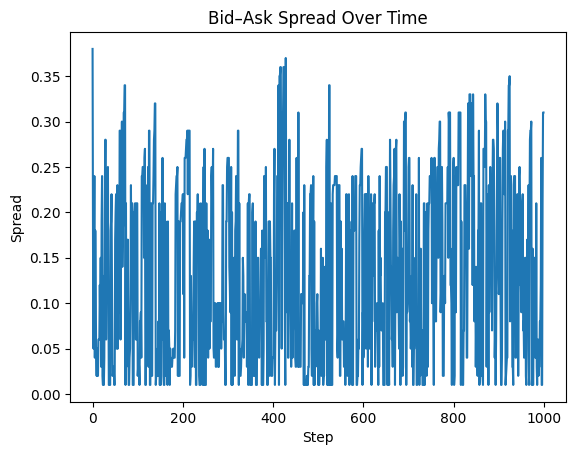

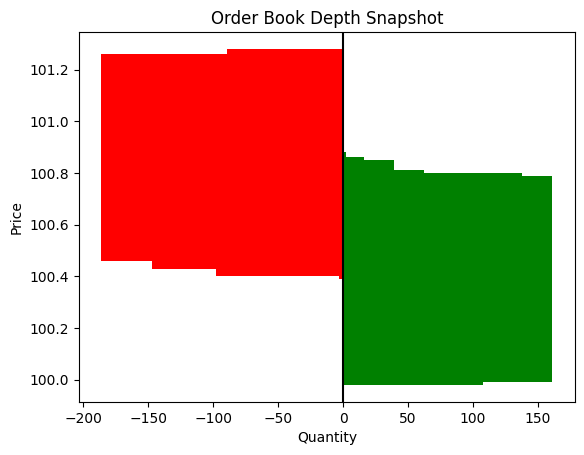

In [2]:
import numpy as np
import random
from collections import defaultdict, deque
import matplotlib.pyplot as plt


# ===================== DATA OBJECTS =====================

class Order:
    def __init__(self, agent_id, side, price, qty, is_market=False):
        self.agent_id = agent_id
        self.side = side              # "buy" or "sell"
        self.price = price            # None for market orders
        self.qty = qty
        self.is_market = is_market


class Trade:
    def __init__(self, price, qty, buy_agent, sell_agent):
        self.price = price
        self.qty = qty
        self.buy_agent = buy_agent
        self.sell_agent = sell_agent


# ===================== ORDER BOOK =====================

class OrderBook:
    def __init__(self):
        self.bids = defaultdict(deque)   # price -> FIFO queue
        self.asks = defaultdict(deque)

    def best_bid(self):
        return max(self.bids.keys()) if self.bids else None

    def best_ask(self):
        return min(self.asks.keys()) if self.asks else None

    def add_limit(self, order):
        book = self.bids if order.side == "buy" else self.asks
        book[order.price].append(order)

    def match(self):
        trades = []
        while self.bids and self.asks and self.best_bid() >= self.best_ask():
            bb = self.best_bid()
            ba = self.best_ask()

            bid_order = self.bids[bb][0]
            ask_order = self.asks[ba][0]

            qty = min(bid_order.qty, ask_order.qty)
            price = (bb + ba) / 2

            trades.append(
                Trade(price, qty, bid_order.agent_id, ask_order.agent_id)
            )

            bid_order.qty -= qty
            ask_order.qty -= qty

            if bid_order.qty <= 0:
                self.bids[bb].popleft()
                if not self.bids[bb]:
                    del self.bids[bb]

            if ask_order.qty <= 0:
                self.asks[ba].popleft()
                if not self.asks[ba]:
                    del self.asks[ba]

        return trades


# ===================== LOGGER =====================

class Logger:
    def __init__(self):
        self.trades = []
        self.best_bid = []
        self.best_ask = []


# ===================== BASE AGENT =====================

class Agent:
    def __init__(self, agent_id):
        self.agent_id = agent_id

    def step(self, env):
        raise NotImplementedError


# ===================== AGENTS =====================

class RandomTrader(Agent):
    def step(self, env):
        side = random.choice(["buy","sell"])
        mid = env.mid_price()
        price = round(mid + np.random.normal(0,0.5), 2)
        qty = random.randint(1,5)
        return Order(self.agent_id, side, price, qty)


class MarketTaker(Agent):
    def step(self, env):
        side = random.choice(["buy","sell"])
        qty = random.randint(1,5)
        return Order(self.agent_id, side, None, qty, is_market=True)


class MarketMaker(Agent):
    def step(self, env):
        mid = env.mid_price()
        spread = 0.2
        return [
            Order(self.agent_id,"buy", round(mid-spread,2), 3),
            Order(self.agent_id,"sell",round(mid+spread,2), 3)
        ]


class NoiseTrader(Agent):
    def __init__(self, agent_id, lam=0.3):
        super().__init__(agent_id)
        self.lam = lam

    def step(self, env):
        if np.random.rand() < self.lam:
            side = random.choice(["buy","sell"])
            mid = env.mid_price()
            price = round(mid + np.random.normal(0,1),2)
            return Order(self.agent_id, side, price, 1)
        return None


# ===================== MARKET ENVIRONMENT =====================

class MarketEnvironment:
    def __init__(self, agents, tick=0.01, spread_floor=0.01):
        self.book = OrderBook()
        self.logger = Logger()
        self.agents = agents
        self.tick = tick
        self.spread_floor = spread_floor

    def mid_price(self):
        b = self.book.best_bid()
        a = self.book.best_ask()
        if b and a:
            return (a+b)/2
        return 100

    def submit(self, order):
        if order is None:
            return

        if order.is_market:
            if order.side=="buy":
                best = self.book.best_ask()
            else:
                best = self.book.best_bid()

            if best is None:
                return

            order.price = best

        self.book.add_limit(order)

        trades = self.book.match()
        for t in trades:
            self.logger.trades.append(t)

    def run(self, steps=500):
        for t in range((steps)):

            for agent in self.agents:
                output = agent.step(self)

                if isinstance(output,list):
                    for o in output:
                        self.submit(o)
                else:
                    self.submit(output)

            self.logger.best_bid.append(self.book.best_bid())
            self.logger.best_ask.append(self.book.best_ask())


# ===================== RUN =====================

agents = [
    RandomTrader(1),
    RandomTrader(2),
    MarketMaker(3),
    MarketTaker(4),
    NoiseTrader(5, lam=0.4)
]

env = MarketEnvironment(agents)
env.run(steps=1000)


# ===================== VISUALIZATION =====================

bids = np.array(env.logger.best_bid, dtype=float)
asks = np.array(env.logger.best_ask, dtype=float)

mask = ~np.isnan(bids) & ~np.isnan(asks)
spread = asks[mask] - bids[mask]

plt.figure()
plt.plot(spread)
plt.title("Bid–Ask Spread Over Time")
plt.xlabel("Step")
plt.ylabel("Spread")
plt.show()


# ----- Depth Snapshot -----

bids = sorted(env.book.bids.items(), reverse=True)[:10]
asks = sorted(env.book.asks.items())[:10]

bid_prices = [p for p,_ in bids]
bid_qtys = [sum(o.qty for o in q) for _,q in bids]

ask_prices = [p for p,_ in asks]
ask_qtys = [sum(o.qty for o in q) for _,q in asks]

plt.figure()
plt.barh(bid_prices, bid_qtys, color="green")
plt.barh(ask_prices, -np.array(ask_qtys), color="red")
plt.axvline(0,color="black")
plt.title("Order Book Depth Snapshot")
plt.xlabel("Quantity")
plt.ylabel("Price")
plt.show()
